# Subpace Inference for Neural ODE's

Ordinary differential equations and machine learning are used to model any non linear systems. Consider a system with input `x` and output `y`, the system representation uisng machine learning will be as below
```
y = ML(x)
```
The training process in machine learning optimizes the paramters of neural network to generate likelihood out to the actual. This machine learning modelling can be used for non linear system by referring universal approximation(UA) theorem. Acording to UA, with enough layers or enough parameters ML representation can approximate any nonlinear function sufficiently close. But the machine learning models requires large set of training data for the proper modelling.

Another solution is to you ordinary differential equations. For ODE base representation, knowledge about the structure of the system is necessary. For example, the birth rate of a prey in a habitat is depends on current population.
```julia
    prey birth rate = α*(current prey population)
```
The `α` is a learnable parameter and the solution of the ODE is `prey_population(t0)exp(α*t)` and simply it is an exponential relation. This embedding the model structure using ODE's doen't require any training data. Threrefore, OSE is helpful for modelling to avoid data hungry of machine learning models. Both modelling methods have advantages and disadvantages. 

Neural ODE's are introduced to model a system by combining machine learning and ODE's together. This meathod is trying to model ODE representation of a system using machine learning method
Instead of 
```
y = ML(x)
```
neural ODE's trying to model as
```
y' = ML(x)
```
[DiffEqFlux.jl](https://github.com/SciML/DiffEqFlux.jl) package helps to implement Neural ODE's in Julia.

### Example of Neural ODE

Lokta Voltera ODE's is used for the study and it is represented as:
```
x' = αx+βxy
y' = −δy+γxy
 ```

In [1]:
using Flux, DiffEqFlux;
using BSON: @save;
using BSON: @load;
using Zygote;
using SubspaceInference;
using DifferentialEquations;
using PyPlot;
using Flux: Data.DataLoader;
using Flux: @epochs;
using Distributions;

┌ Info: Precompiling SubspaceInference [706446a6-0e85-4c47-b731-c658bbb72625]
└ @ Base loading.jl:1313


## Set up Spiral ODE

### Define inital conditions and time span

In [2]:
len = 100
u0 = Array{Float64}(undef,2,len)
u0 .= [2.; 0.]
datasize = 30
tspan = (0.0,1.5)


(0.0, 1.5)

### Deine ODE

In [3]:
function trueODEfunc(du,u,p,t)
    true_A = [-0.1 2.0; -2.0 -0.1]
    du .= ((u.^3)'true_A)'
end


trueODEfunc (generic function with 1 method)

### Generate time span

In [4]:
t = range(tspan[1],tspan[2],length=datasize)

0.0:0.05172413793103448:1.5

### Solve ODE and add noise to solution

In [5]:
ode_data = Array{Float64}(undef, 2*datasize, len)
for i in 1:len
	prob = ODEProblem(trueODEfunc,u0[:,i],tspan)
	ode_data[:,i] = reshape(Array(solve(prob,Tsit5(),saveat=t))', :, 1)
end
ode_data_bkp = ode_data
ode_data += rand(Normal(0.0,0.1), 2*datasize,len);

### Plot solution with noise

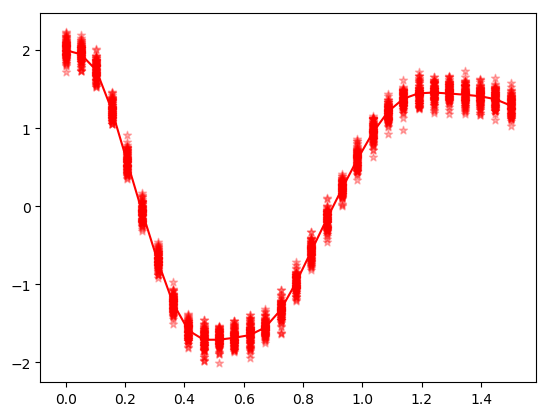

In [6]:
(fig, f_axes) = PyPlot.subplots(ncols=1, nrows=1)
for i in 1:len
	f_axes.scatter(t,vec(ode_data[1:1:datasize,i]), c="red", alpha=0.3, marker="*", label ="data with noise")
end
f_axes.plot(t,vec(ode_data_bkp[1:1:datasize,1]), c="red", marker=".", label = "data")
fig.show();

### Setting up Neural ODE

In [7]:
dudt = Chain(x -> x.^3, Dense(2,15,tanh),
             Dense(15,2))
n_ode = NeuralODE(dudt,tspan,Tsit5(),saveat=t,
	reltol=1e-7,abstol=1e-9);

### Extract NN params and define loss function and optimizer

In [8]:
ps = Flux.params(n_ode);

sqnorm(x) = sum(abs2, x)
L1(x, y) = sum(abs2, n_ode(vec(x)) .- 
	reshape(y[:,1], :,2)')+sum(sqnorm, Flux.params(n_ode))/100
#call back
cb = function () #callback function to observe training
  @show L1(u0[:,1], ode_data_bkp[:,1])
end

#optiizer
opt = ADAM(0.1);

### Zip initial condition and solution for training

In [9]:
#format data
X = u0 #input
Y =ode_data #output 

data =  DataLoader(X,Y);

### Pretrain Neural ODE

In [ ]:
# @epochs 4 Flux.train!(L1, ps, data, opt);
# cb();

### Save trained parameters for future use

In [ ]:
# @save "n_ode_weights_30r.bson" ps;

### Load trained parameters

In [10]:
@load "n_ode_weights_30r.bson" ps;
Flux.loadparams!(n_ode, ps);
pred = n_ode(vec(u0[:,1]));

### Plotactual and predicted soulution

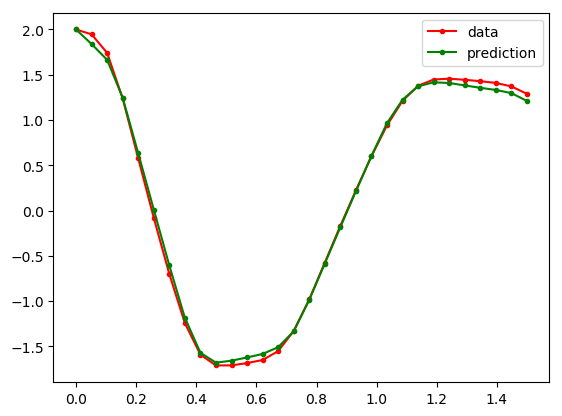

In [11]:
(fig, f_axes) = PyPlot.subplots(ncols=1, nrows=1)
pred = n_ode(vec(u0[:,1])) # Get the prediction using the correct initial condition
f_axes.plot(t,vec(ode_data_bkp[1:datasize,1]), c="red", marker=".", label = "data")
f_axes.plot(t,vec(pred[1,:]), c="green", marker=".", label ="prediction")
f_axes.legend()
fig.show()

### Modify loss function for subspace inference

In [13]:
L1(m, x, y) = sum(abs2, m(vec(x)) .- reshape(y[:,1], :,2)')+sum(sqnorm, Flux.params(m))/100;

### Generate subspace inference

In [14]:
T = 1
M = 3
itr = 100
σ_z = 0.1 #proposal distribution

#do subspace inference
chn, lp, W_swa = SubspaceInference.subspace_inference(n_ode, L1, data, opt;
	σ_z = σ_z, itr =itr, T=T, M=M,  alg =:mh);

Traing loss: 1.8175580824142323 Epoch: 

Sampling:   2%|█                                        |  ETA: 0:00:55

1


Sampling: 100%|█████████████████████████████████████████| Time: 0:01:55


### Plot uncertainty

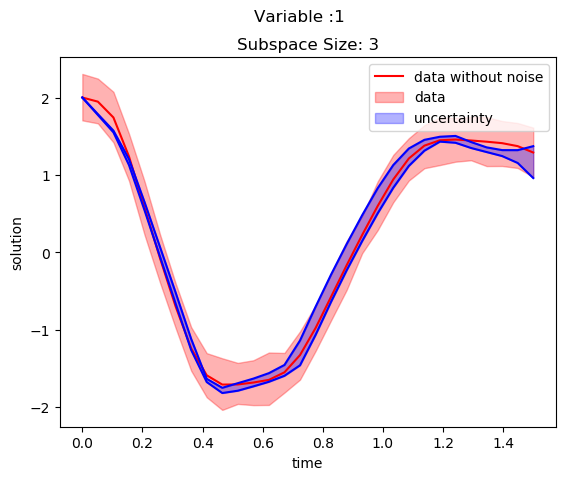

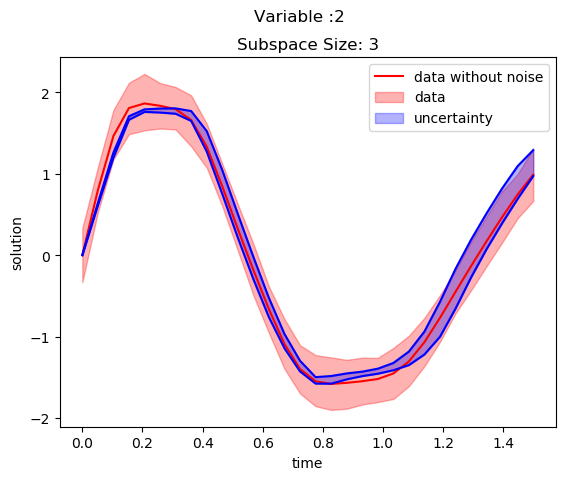

In [18]:
ns = length(chn)

trajectories = Array{Float64}(undef,2*datasize,ns)
for i in 1:ns
  new_model = SubspaceInference.model_re(n_ode, chn[i])
  out = new_model(u0[:,1])
  reshape(Array(out)',:,1)
  trajectories[:, i] = reshape(Array(out)',:,1)
end

all_trajectories = Dict()
all_trajectories[1] = trajectories
title = ["Subspace Size: $M"]

SubspaceInference.plot_node(t, all_trajectories, ode_data_bkp, ode_data, 2, datasize, title)